# Event separation

## Importation

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
import scipy
from functools import partial
import seaborn as sns
import calendar
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.colors as mcolors
from DL_Data import DL_Data

## Data Treatment

In [7]:
# Paramètres des données
Stations = ['Aigle', 'Pully', 'Payerne', 'Fretaz', 'Dole', 'Nyon', 'Moleson', 'Zermatt', 'Adelboden']
num_sta = 5

Path = "../Database/Precipitations"
df = DL_Data(Path, Stations[num_sta])

print('\nDonnées sélectionnées: \n\n\tStation: '+Stations[num_sta])
df = df.reset_index(drop=True)

value_column = df.columns[1]
df[value_column] = pd.to_numeric(df[value_column], errors='coerce')



Données sélectionnées: 

	Station: Nyon


## Isolating the events

In [8]:
events_pd = np.zeros(len(df[value_column]))
time_limit = 6*2
in_index = False
time_count = 0
event_count = 1
index = 0
years = df['time'].dt.year.unique()

for i, p in enumerate(df[value_column]):
    if p != 0:
        time_count = 0
        if in_index == False:
            in_index = True
            index = i            
    if p == 0:
        time_count += 1
        if time_count >= time_limit and in_index == True:
            in_index = False
            events_pd[index:i-time_limit+1] = event_count
            event_count += 1

df['events'] = events_pd

## Treating the events data

In [9]:
events_sum = df.groupby('events')[value_column].sum()
events_sum_pd = np.zeros(shape=[len(df[value_column])])
for i, e in enumerate(df['events']):
    events_sum_pd[i] = events_sum[int(e)]
df['events_sum'] = events_sum_pd

Ici les données interessantes sont tirées du tableau df. Events contient l'intensité de chaque evenements, durations contient la durée de chaque evenement, Intensities contient le rapport des deux. Peaks per year, contient le nombre d'événements qui dépassent un certain treshold en fonction de la tranche d'années sélectionnée.

In [10]:
start_times = df.groupby('events')['time'].min()
end_times = df.groupby('events')['time'].max()
durations = np.array((end_times - start_times).dt.total_seconds())/(60*60)+(1/6)
time_btwn_events = np.zeros(len(start_times)-2)
for i in range(len(start_times)):
   if i>1:
    time_btwn_events[i-2] = (start_times[i] - end_times[i-1]).total_seconds()/(60*60)

events = df.groupby('events')['events_sum'].first().values

# Deleting the 0 event -> corresponding to time without rain
durations = np.delete(durations,0)
events = np.delete(events,0)
start_times = np.delete(start_times,0)
Intensities = events/durations
time_ratio = Intensities[:-1]/time_btwn_events

# Test of looking at the evolution through the years of the cumul of subhourly rains -> Doesn't lead to any trend
width_mobile = 10
num_mobile = years[-1]-years[0]-width_mobile
tresholds = np.arange(20,50,1)
peaks_per_year = np.zeros(shape=[num_mobile, len(tresholds)])

for i in range(num_mobile):
  for j,t in enumerate(tresholds):
    mask = (start_times<=np.datetime64(str(years[0]+i+width_mobile)+'-01-01')) & (start_times>=np.datetime64(str(years[0]+i)+'-01-01')) & (events > t)
    peaks_per_year[i,j] = len(events[mask])

# Plots issu de ces données

Heatmap de peaks per year pour essayer de déceler une tendance au fur et à mesure des années

Text(50.722222222222214, 0.5, 'Treshold')

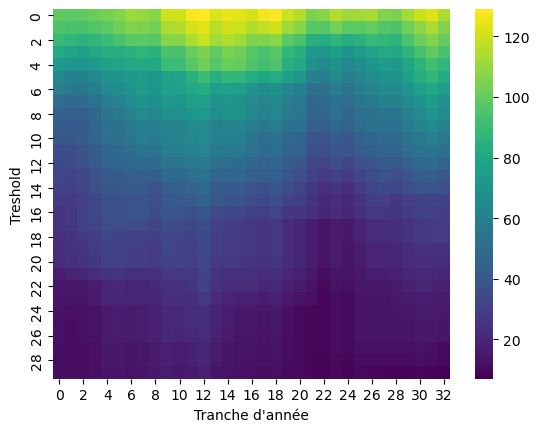

In [18]:
plt.figure()
sns.heatmap(peaks_per_year.transpose(), cmap='viridis')
plt.xlabel("Tranche d'année")
plt.ylabel("Treshold")

Plot Intensité des evenements en fonction de leur durée. Chaque point a une couleur mappée à l'année de l'événement

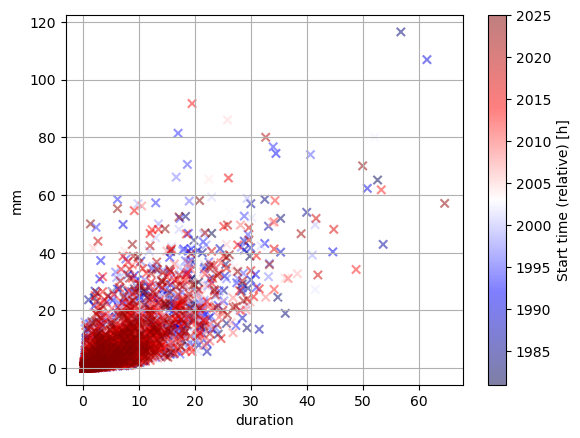

In [19]:
start_times_numeric = 1981+(start_times - start_times.min()) / np.timedelta64(24*365, 'h')
norm = colors.Normalize(vmin=start_times_numeric.min(), vmax=start_times_numeric.max())
colormap = cm.seismic  # ou autre colormap
mapped_colors = colormap(norm(start_times_numeric))

# Création du scatter plot avec couleurs
fig, ax = plt.subplots()
sc = ax.scatter(durations, events, c=start_times_numeric, cmap=colormap, norm=norm, marker='x', alpha=0.5)

# Ajout de la colorbar avec l'objet mappable 'sc'
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Start time (relative) [h]')

# Autres éléments du graphique
ax.grid(True)
ax.set_xlabel('duration')
ax.set_ylabel('mm')
plt.show()


##  Animation of the intensity-duration heatmap

Le but ici est de reprendre le plot précédent mais en comptant le nombre de points par interval intensité durée et en regardant par tranche d'années. Width_mobile controle la largeur des tranches, et grid controle la dimension des intervals durée intensité.

In [20]:
width_mobile = 10
num_mobile = years[-1]-years[0]-width_mobile
grid = 40
maxdur = durations[durations<durations.max()].max()
maxint = events[events<events.max()].max()
grid_int = np.linspace(0,maxint,grid)
grid_dur = np.linspace(0,maxdur,grid)
map_dur_int = np.zeros(shape=[num_mobile,grid,grid])

for w in range(num_mobile):
    for i in range(grid-1):
        for j in range(grid-1):
            mask = (start_times<np.datetime64(str(years[0]+w+width_mobile)+'-01-01'))&(start_times>=np.datetime64(str(years[0]+w)+'-01-01')) & (durations >= grid_dur[i]) & (durations < grid_dur[i+1]) & (events>=grid_int[j]) & (events<grid_int[j+1])
            map_dur_int[w,i,j] = len(events[mask])
            if map_dur_int[w,i,j] > 1000:
                map_dur_int[w,i,j] = 1000

Génération des Frames pour faire une animation (Gif), le gif peut etre créer à partir des frames en utilisant le script Animation.ipynb

In [ ]:
for w in range(num_mobile):
    plt.figure()
    ax = sns.heatmap(map_dur_int[w].transpose(), cmap='viridis', norm=mcolors.LogNorm(vmin=1, vmax=map_dur_int[:,:].max()))
    plt.gca().invert_yaxis()
    plt.title("Station: "+Stations[num_sta]+f'  Années: {years[0]+w}-{years[0]+w+width_mobile}')
    ax.set_xticklabels(np.int64(grid_int[::2]))
    ax.set_yticklabels(np.int64(grid_dur[::2]))
    ax.set_xlabel('Total rain [mm]')
    ax.set_ylabel('Duration [h]')
    plt.savefig(f'../Plots/Animation/Frame_{w}.png')
    plt.close() #Cette ligne peut-être enlevée pour plot les frames (mais c'est très lourd visuellement)

## Test of FFT on the event time serie

Tests de faire une analyse de fourier dans un espace fréquentiel d'unité "par événement". Ce n'est pas très concluant.

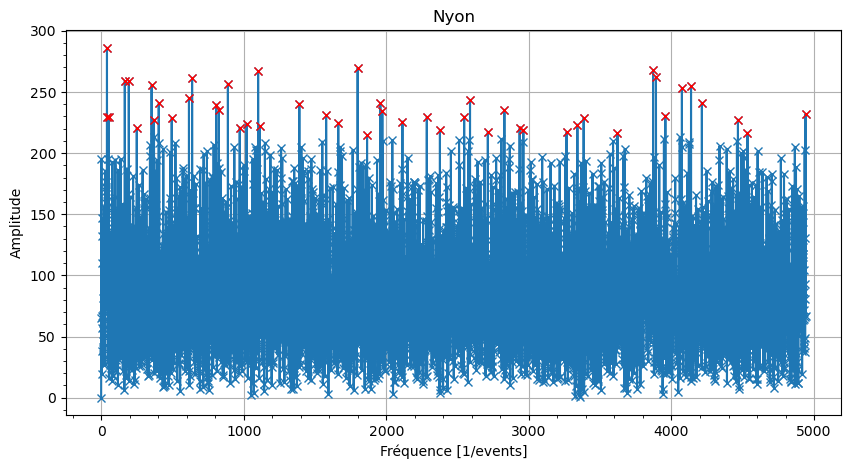

In [15]:
signal = (np.array(events) - np.mean(events))/np.std(events)
fft_vals = np.fft.fft(signal)
fft_freqs = np.fft.fftfreq(len(signal), 1/len(signal))

half_n = len(signal) // 2
fft_vals_clean = np.abs(fft_vals[:half_n])
fft_freqs_clean = fft_freqs[:half_n]

high_val_filter = 0
high_freq_filter = 100

plt.figure(figsize=(10, 5))
plt.plot(fft_freqs_clean[fft_vals_clean>high_val_filter], fft_vals_clean[fft_vals_clean>high_val_filter], 'x-')
plt.plot(fft_freqs_clean[fft_vals_clean>np.max(fft_vals_clean*0.75)], fft_vals_clean[fft_vals_clean>np.max(fft_vals_clean*0.75)], 'xr')
plt.title("Spectre de fréquence")
plt.xlabel("Fréquence [1/events]")
plt.ylabel("Amplitude")
plt.title(Stations[num_sta])
plt.minorticks_on()
plt.grid(True)
plt.show()

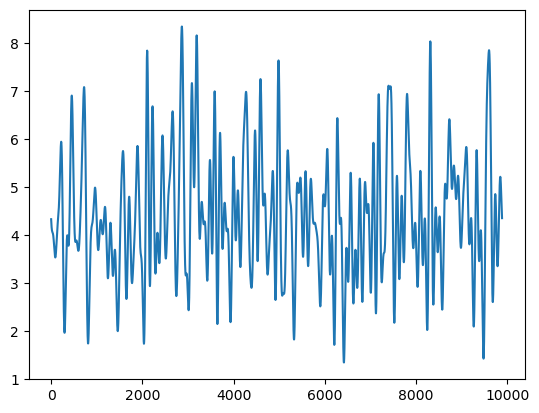

In [16]:
fft_vals[np.abs(fft_vals)<high_val_filter] = 0
fft_vals[np.abs(fft_freqs)>high_freq_filter] = 0
new_signal = np.real(np.fft.ifft(fft_vals))*np.std(events)+np.mean(events)
plt.plot(new_signal)